# Cusp-capturing PINN - Example 2
> Figure~5 - $\phi_a$

* level set augmentation: $\phi_a$
* Optimizer: L-BFGS

### Import packages

In [1]:
import torch 
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [2]:
import numpy as np 
import math
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator

In [3]:
from scipy.interpolate import griddata

# use latin hypercube sampling
from pyDOE import lhs   

# CUDA support 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# enforce double precision
torch.set_default_dtype(torch.float64)

## Parameters 

In [4]:
# domain [a,b]\times[c,d]
ba = -1.
bb = 1.
bc = -1.
bd = 1.
dstab = bb - ba
dstcd = bd - bc
# \beta^+, \beta^-, and \eta
btao = 1
btai = 10.
eta  = btai/btao
bta_jmp = btao - btai
bta_sum = btao + btai
gamma = 2.
alpha = 1.
cfao = alpha/btao
cfai = alpha/btai
# radii of the ellipse
radx = .5
rady = .5
rxsq = radx * radx
rysq = rady * rady
# input_size
input0 = 2
input_size = input0 + 1
# neurons used in hidden layer
n_hidden = 50
# output_size
output_size = 1
# learning_rate
learning_rate = 0.0001
# max. epochs
max_epochs = 100001
# show loss per gp_epochs
gp_epochs = 10000
# Training points
M0 = 30    # point in each direction
N_trd = M0 * M0
N_trb = M0
N_trg = 3 * M0
# number of testing points
N_tsd_final = 100*N_trd
N_tsg_final = 100*N_trg

## Exact solution and source

In [5]:
def levfun(x, y):
    qo = x*x/rxsq + y*y/rysq - 1.0
    q = np.zeros( (len(x),6) )
    q[:,0:1] = qo
    q[:,1:2] = 2.*x/rxsq
    q[:,2:3] = 2.*y/rysq
    q[:,3:4] = 2./rxsq + 2./rysq    
    for i in range(len(x)):
        if qo[i] >= 0.:
            q[i,:] = q[i,:]
        else:
            q[i,:] = - q[i,:]
    q[:,4:5] = q[:,1:2] * q[:,1:2] + q[:,2:3] * q[:,2:3]
    q[:,5:6] = alpha/exact_b(x, y, qo)
    return qo, q


def levfun_grad(x, y):  # for BCs
    qvec = np.hstack( ( 2*x/rxsq , 2*y/rysq ) )
    return qvec


def lvnorvec(x, y):
    qnorvec = np.zeros( (len(x),2) )
    dqx = 2*x/rxsq
    dqy = 2*y/rysq
    dqsqrt = np.sqrt( dqx*dqx + dqy*dqy )
    qnorvec[:,0:1] = dqx/dqsqrt
    qnorvec[:,1:2] = dqy/dqsqrt
    return qnorvec, dqsqrt


# exact solution of example 01 and 02
def exact_u(x, y, z):
    eu = np.zeros_like(z)
    dd = x*x/rxsq + y*y/rysq
    for i in range(len(z)):
        if z[i] >= 0.:
            eu[i] = - gamma*np.log( dd[i] )
        else:
            eu[i] = 1. - np.exp( (dd[i]-1.)/eta )
    return eu


def exact_gradu(x, y, z):
    eux = np.zeros_like(z)
    euy = np.zeros_like(z)
    dd = x*x/rxsq + y*y/rysq
    cfxp = -2*gamma/rxsq
    cfyp = -2*gamma/rysq
    cfxn = -2/(rxsq*eta)
    cfyn = -2/(rysq*eta)
    for i in range(len(z)):
        if z[i] >= 0.:
            eux[i] = cfxp*( x[i]/dd[i] )
            euy[i] = cfyp*( y[i]/dd[i] )
        else:
            tp = np.exp( (dd[i]-1.)/eta )
            eux[i] = cfxn*x[i]*tp
            euy[i] = cfyn*y[i]*tp
    return eux, euy


def exact_BCs(x, y, dbc, nbc, n1, n2): # Robin: a*u + b*dun = c
    # example 01
    dd = x*x/rxsq + y*y/rysq 
    u  = - gamma*np.log( dd )
    ux = (-2*gamma/rxsq)*(x/dd)
    uy = (-2*gamma/rysq)*(y/dd)
    ubc = dbc*u + nbc*( ux*n1 + uy*n2 )
    return ubc


def exact_b(x, y, z):
    eb = np.zeros_like(z)
    for i in range(len(z)):
        if z[i] >= 0.:
            eb[i] = btao
        else:
            eb[i] = btai
    return eb


# normal derivative jump of level set function
def jump_lvdn(x, y):
    qdn_jmp = 4 * np.sqrt( x*x/(rxsq*rxsq) + y*y/(rysq*rysq) )
    return qdn_jmp


# normal derivative jump condition along interface:
def jump_btadun(x, y):
    dun = - 4*(btao*gamma-btai/eta)*np.ones_like(x)
    return dun


# source
def lapu(x, y, z):
    eu = exact_u(x, y, z)
    dd = x*x/rxsq + y*y/rysq
    gdD2 = 4.*( x*x/(rxsq*rxsq) + y*y/(rysq*rysq) )
    lapD = np.ones_like(z) * ( 2./rxsq + 2./rysq )
    ef = np.zeros_like(z)
    for i in range(len(z)):
        if z[i] >= 0.:
            ef[i] = ( gdD2[i]/dd[i] - lapD[i] )/dd[i] - cfao*eu[i]
        else:
            ef[i] = - np.exp((dd[i]-1.)/eta)*( lapD[i] + gdD2[i]/eta )/eta - cfai*eu[i]            
    return ef

## Training points, boundary conditions and Jump conditions

In [6]:
# Boundary points 
## Xb: points at the boundary
xb = ba + dstab*lhs(1, N_trb)
yb = bc + dstcd*lhs(1, N_trb)
tpx = np.ones_like(xb)
tpy = np.ones_like(yb)
sbx = np.vstack( ( ba*tpy , bb*tpy , xb     , xb     ) )
sby = np.vstack( ( yb     , yb     , bc*tpx , bd*tpx ) )
pgd = levfun_grad(sbx, sby)
qbo, qb = levfun(sbx , sby)
bn1 = np.vstack( ( -tpy , tpy , np.zeros((N_trb,1)) , np.zeros((N_trb,1)) ) )
bn2 = np.vstack( ( np.zeros((N_trb,1)) , np.zeros((N_trb,1)) , -tpx , tpx ) )
Dbc = np.vstack( ( 1*tpy , 1*tpy , 0*tpx , 0*tpx ) )
Nbc = np.vstack( ( 0*tpy , 0*tpy , 1*tpx , 1*tpx ) )
# Boundary condition
fb = exact_BCs(sbx, sby, Dbc, Nbc, bn1, bn2)
Nb_new = len(fb)
# combine
Xb = np.hstack( ( sbx , sby , qb[:,0:1] ) )
Fb = np.hstack( ( fb , bn1 , bn2 , pgd , Dbc , Nbc ) )
print(f'No. of training points at the outer boundary is {4*M0}')

# Interior points M0 * M0
sampling = lhs(2, N_trd)
xd = ba + dstab*sampling[:,0:1]
yd = bc + dstcd*sampling[:,1:2]
qdo, qd = levfun(xd, yd)
# remove points at the interface
qid = np.where(np.abs(qdo)<5e-16)
qd  = np.delete(qd, qid[0], 0)
xd  = np.delete(xd, qid[0], 0)
yd  = np.delete(yd, qid[0], 0)
qdo = np.delete(qdo, qid[0], 0)    
# torch tensor and requires_grad
Xd = np.hstack( ( xd , yd , qd[:,0:1] ) )  
# right hand side
fd = lapu(xd, yd, qdo)
Fd = np.hstack( ( fd , qd[:,1:] ) )
N_trd_new = len(fd)

print(f'No. of training points in the bulk domain is {N_trd_new}')

## X_gma: points on the interface N_gma
#np.random.seed(1234)
thet = 2*np.pi*lhs(1, N_trg)
xg = 0.5*(ba+bb) + radx*np.cos(thet)
yg = 0.5*(bc+bd) + rady*np.sin(thet)
zg = np.zeros_like(xg)
Xg = np.hstack( ( xg , yg , zg ) )
# normal vector along the interface
norvec, dqnorm = lvnorvec(xg, yg)
# normal derivative jump condition for u
flux_jp = jump_btadun(xg, yg)     
# combine and torch tensor
Fg = np.hstack( ( flux_jp, norvec , bta_jmp*np.ones_like(flux_jp) , bta_sum*dqnorm ) )

print(f'No. of training points at the interface is N_gma = {N_trg}')

print(f'Total number of training points: {N_trd_new+4*N_trb+N_trg}')

# Interior points M0 * M0
sampling = lhs(2, N_tsd_final)
xd = ba + dstab*sampling[:,0:1]
yd = bc + dstcd*sampling[:,1:2]
qdo, qd = levfun(xd, yd)
# remove points at the interface
qid = np.where(np.abs(qdo)<5e-16)
qd  = np.delete(qd, qid[0], 0)
xd  = np.delete(xd, qid[0], 0)
yd  = np.delete(yd, qid[0], 0)
qdo = np.delete(qdo, qid[0], 0)    
# exact solution of u
ref_u_tsd = exact_u(xd, yd, qdo)
ref_u_tsd_infnorm = np.linalg.norm(ref_u_tsd, np.inf) 
ref_u_tsd_L2norm  = np.linalg.norm(ref_u_tsd, 2)
# torch tensor and requires_grad
Xd_ts = np.hstack( ( xd , yd , qd[:,0:1] ) )   

No. of training points at the outer boundary is 120
No. of training points in the bulk domain is 900
No. of training points at the interface is N_gma = 90
Total number of training points: 1110


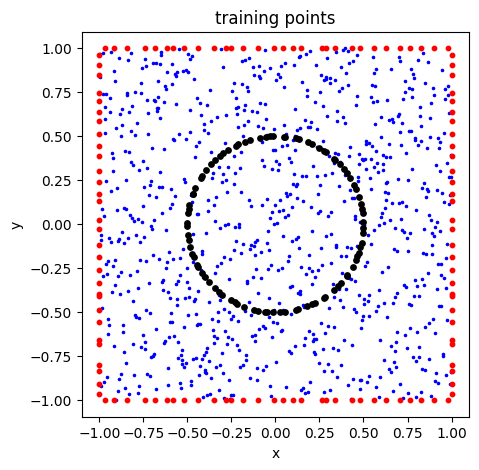

In [7]:
plt.figure(figsize = (5,5))

plt.scatter(Xd[:,0], Xd[:,1], c = "b", s = 10, marker = ".") 
plt.scatter(Xb[:,0], Xb[:,1], c = "r", s = 40, marker = ".")
plt.scatter(Xg[:,0], Xg[:,1], c = "k", s = 60, marker = ".")
plt.xlabel('x')
plt.ylabel('y')
plt.axis('equal')
plt.title('training points')

plt.show()

## Neural network structure

One hidden layer

* [Avaliable activation function - Torch](https://pytorch.org/docs/stable/nn.html)


In [8]:
# the deep neural network
class NeuralNet(nn.Module):
    def __init__(self):
        super(NeuralNet, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(input_size, n_hidden),
            nn.Sigmoid(),
            #nn.Tanh(),
            nn.Linear(n_hidden, output_size, bias=False),
        )
        
    def forward(self, x):
        out = self.net(x)
        return out

#將模型print出來看看
func = NeuralNet()
print(func)

NeuralNet(
  (net): Sequential(
    (0): Linear(in_features=3, out_features=50, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=50, out_features=1, bias=False)
  )
)


In [9]:
# the physics-guided neural network
class PhysicsInformedNN():
    def __init__(self, Xd, Fd, Xb, Fb, Xg, Fg, Xd_ts):
        
        # data
        self.xd = torch.tensor(Xd[:,0:1], requires_grad=True).double().to(device)
        self.yd = torch.tensor(Xd[:,1:2], requires_grad=True).double().to(device)
        self.zd = torch.tensor(Xd[:,2:3], requires_grad=True).double().to(device)
        self.fd = torch.tensor(Fd).double().to(device)
        self.xb = torch.tensor(Xb[:,0:1], requires_grad=True).double().to(device)
        self.yb = torch.tensor(Xb[:,1:2], requires_grad=True).double().to(device)
        self.zb = torch.tensor(Xb[:,2:3], requires_grad=True).double().to(device)
        self.fb = torch.tensor(Fb[:,0:1]).double().to(device)
        self.nb1 = torch.tensor(Fb[:,1:2]).double().to(device)
        self.nb2 = torch.tensor(Fb[:,2:3]).double().to(device)
        self.pb1 = torch.tensor(Fb[:,3:4]).double().to(device)
        self.pb2 = torch.tensor(Fb[:,4:5]).double().to(device)
        self.alp = torch.tensor(Fb[:,5:6]).double().to(device)
        self.bta = torch.tensor(Fb[:,6:7]).double().to(device)
        self.xg = torch.tensor(Xg[:,0:1], requires_grad=True).double().to(device)
        self.yg = torch.tensor(Xg[:,1:2], requires_grad=True).double().to(device)
        self.zg = torch.tensor(Xg[:,2:3], requires_grad=True).double().to(device)
        self.fg = torch.tensor(Fg).double().to(device)
        
        self.xd_ts = torch.tensor(Xd_ts[:,0:1]).double().to(device)
        self.yd_ts = torch.tensor(Xd_ts[:,1:2]).double().to(device)
        self.zd_ts = torch.tensor(Xd_ts[:,2:3]).double().to(device)
        
        # deep neural networks
        self.nn = NeuralNet().double().to(device)
        
        # optimizers: using the same settings
        self.optimizer = torch.optim.LBFGS(self.nn.parameters(), lr=learning_rate, 
                                           max_iter=20000, max_eval=max_epochs, history_size=50,
                                           tolerance_grad=np.finfo(float).eps, 
                                           tolerance_change=np.finfo(float).eps,
                                           line_search_fn="strong_wolfe")

        # counter and value of loss
        self.epoch = 0
        self.loss0 = 1.
        self.epochval = []
        self.lossval = []
        
    ## u from network
    def net_u(self, x, y, z):  
        u = self.nn(torch.cat([x, y, z], dim=1))
        return u
    
    
    ## loss function
    def loss_func(self):
        # Backward and optimize
        self.optimizer.zero_grad()
        
        # u 
        u = self.net_u(self.xd, self.yd, self.zd)
        # first and second derivatives
        u_x = torch.autograd.grad(u, self.xd, grad_outputs=torch.ones_like(u),
                                  retain_graph=True, create_graph=True)[0]
        u_y = torch.autograd.grad(u, self.yd, grad_outputs=torch.ones_like(u),
                                  retain_graph=True, create_graph=True)[0]
        u_z = torch.autograd.grad(u, self.zd, grad_outputs=torch.ones_like(u),
                                  retain_graph=True, create_graph=True)[0]
        u_xx = torch.autograd.grad(u_x, self.xd, grad_outputs=torch.ones_like(u_x),
                                   retain_graph=True, create_graph=True)[0]
        u_xz = torch.autograd.grad(u_x, self.zd, grad_outputs=torch.ones_like(u_x),
                                   retain_graph=True, create_graph=True)[0]
        u_yy = torch.autograd.grad(u_y, self.yd, grad_outputs=torch.ones_like(u_y),
                                   retain_graph=True, create_graph=True)[0]
        u_yz = torch.autograd.grad(u_y, self.zd, grad_outputs=torch.ones_like(u_y),
                                   retain_graph=True, create_graph=True)[0]
        u_zz = torch.autograd.grad(u_z, self.zd, grad_outputs=torch.ones_like(u_z),
                                   retain_graph=True, create_graph=True)[0]
        # residual
        Res_d = u_xx + u_yy + 2.*( u_xz*self.fd[:,1:2] + u_yz*self.fd[:,2:3] )  \
                + u_z*self.fd[:,3:4] + u_zz*self.fd[:,4:5] - u*self.fd[:,5:6] - self.fd[:,0:1]
        
        ### u from NN (bulk region)
        lossd = torch.mean(Res_d*Res_d)

        
        ### boundary error
        ub = self.net_u(self.xb, self.yb, self.zb)
        ub_x = torch.autograd.grad(ub, self.xb, grad_outputs=torch.ones_like(ub),
                                   retain_graph=True, create_graph=True)[0]
        ub_y = torch.autograd.grad(ub, self.yb, grad_outputs=torch.ones_like(ub),
                                   retain_graph=True, create_graph=True)[0]
        ub_z = torch.autograd.grad(ub, self.zb, grad_outputs=torch.ones_like(ub),
                                   retain_graph=True, create_graph=True)[0]
        errb = self.alp*ub + self.bta*( (ub_x+ub_z*self.pb1)*self.nb1 + (ub_y+ub_z*self.pb2)*self.nb2 ) - self.fb
        lossb = torch.mean(errb*errb)
        
        
        ### interfacial error
        ug = self.net_u(self.xg, self.yg, self.zg) 
        # gradient of u
        ug_x = torch.autograd.grad(ug, self.xg, grad_outputs=torch.ones_like(ug), 
                                      retain_graph=True, create_graph=True)[0]
        ug_y = torch.autograd.grad(ug, self.yg, grad_outputs=torch.ones_like(ug), 
                                      retain_graph=True, create_graph=True)[0]
        ug_z = torch.autograd.grad(ug, self.zg, grad_outputs=torch.ones_like(ug), 
                                      retain_graph=True, create_graph=True)[0]
        errg = self.fg[:,3:4]*(ug_x*self.fg[:,1:2]+ug_y*self.fg[:,2:3]) + ug_z*self.fg[:,4:5] - self.fg[:,0:1]
        lossg = torch.mean(errg*errg)
        
        
        # total loss
        loss = lossd + lossb + lossg
        loss.backward()
        rloss = loss/self.loss0

        with torch.no_grad():
            if ( self.epoch % gp_epochs == 1 ) or ( rloss<0.2 ):
                self.epochval.append( (self.epoch) )
                self.lossval.append((loss.item(), lossd.item(), lossb.item(), lossg.item()))
                print(f'epoch= {self.epoch:}')
                print(f'Loss = {loss.item():.2e}, Lossd = {lossd.item():.2e}, Lossb = {lossb.item():.2e}, Lossg= {lossg.item():.2e}')                
                self.loss0 = loss
                
        self.epoch += 1
        
        return loss

    
    ## training
    def train(self):
        self.nn.train()
        self.optimizer.step(self.loss_func)
            
    
    ## prediction
    def predict(self, X):
        x = torch.tensor(X[:, 0:1], requires_grad=True).double().to(device)
        y = torch.tensor(X[:, 1:2], requires_grad=True).double().to(device)
        z = torch.tensor(X[:, 2:3], requires_grad=True).double().to(device)
        self.nn.eval()
        u = self.net_u(x, y, z).detach().cpu().numpy()
        return u

## Train the model

In [10]:
model = PhysicsInformedNN(Xd, Fd, Xb, Fb, Xg, Fg, Xd_ts)

In [11]:
lossval=model.train()

epoch= 1
Loss = 2.01e+01, Lossd = 3.46e+00, Lossb = 8.39e+00, Lossg= 8.30e+00
epoch= 261
Loss = 4.03e+00, Lossd = 2.19e+00, Lossb = 1.71e+00, Lossg= 1.28e-01
epoch= 1260
Loss = 8.05e-01, Lossd = 7.02e-01, Lossb = 7.33e-02, Lossg= 2.90e-02
epoch= 2486
Loss = 1.61e-01, Lossd = 1.41e-01, Lossb = 1.36e-02, Lossg= 6.13e-03
epoch= 5601
Loss = 3.22e-02, Lossd = 2.75e-02, Lossb = 3.74e-03, Lossg= 8.97e-04
epoch= 10001
Loss = 1.07e-02, Lossd = 9.21e-03, Lossb = 1.33e-03, Lossg= 1.24e-04
epoch= 20001
Loss = 2.60e-03, Lossd = 2.35e-03, Lossb = 1.79e-04, Lossg= 7.37e-05
epoch= 30001
Loss = 1.45e-03, Lossd = 1.29e-03, Lossb = 1.26e-04, Lossg= 3.16e-05
epoch= 40001
Loss = 9.38e-04, Lossd = 8.40e-04, Lossb = 8.05e-05, Lossg= 1.78e-05
epoch= 50001
Loss = 5.87e-04, Lossd = 5.35e-04, Lossb = 3.39e-05, Lossg= 1.82e-05
epoch= 60001
Loss = 4.53e-04, Lossd = 4.20e-04, Lossb = 2.12e-05, Lossg= 1.12e-05
epoch= 70001
Loss = 4.01e-04, Lossd = 3.69e-04, Lossb = 2.71e-05, Lossg= 5.34e-06
epoch= 80001
Loss = 3.42e

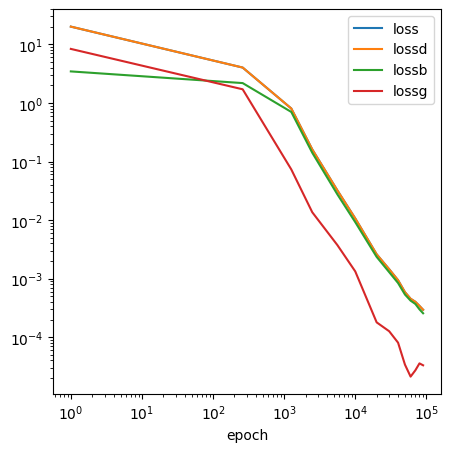

In [12]:
plt.figure(figsize = (5,5))
epochcol = np.array(model.epochval)
result = np.array(model.lossval)
loss = result[:,0]
loss_d = result[:,0:1]
loss_b = result[:,1:2]
loss_g = result[:,2:3]

plt.loglog(epochcol, loss)
plt.loglog(epochcol, loss_d)
plt.loglog(epochcol, loss_b)
plt.loglog(epochcol, loss_g)
plt.legend(['loss', 'lossd', 'lossb', 'lossg'], loc='upper right')
plt.xlabel('epoch')
plt.show()

## Testing

In [13]:
# No. of testing points
print(f'No. of testing point: N_in ({N_tsd_final}) + N_gma ({N_tsg_final}) = {N_tsd_final+N_tsg_final}')

# fixed pseudo random generator
#np.random.seed(777)

##### generate interior testing points and calculate error
X_ts = lhs(2, N_tsd_final)
x_ts = ba + dstab * X_ts[:,0:1]
y_ts = bc + dstcd * X_ts[:,1:2]
qdo_ts, qd_ts = levfun(x_ts, y_ts)
# exact solution of u
eu_ts = exact_u(x_ts, y_ts, qdo_ts)
# prediction of u
X_ts = np.hstack( ( x_ts , y_ts , qd_ts[:,0:1] ) )
upred_ts = model.predict(X_ts)
# Error at the interior points
err = np.absolute(upred_ts - eu_ts)

err_u_2r = np.linalg.norm(err, 2) / np.linalg.norm(eu_ts, 2)
print('Error u (relative 2-norm): %e' % (err_u_2r))
err_u_infr = np.linalg.norm(err, np.inf) / np.linalg.norm(eu_ts, np.inf)
print('Error u (relative inf-norm): %e' % (err_u_infr))

No. of testing point: N_in (90000) + N_gma (9000) = 99000
Error u (relative 2-norm): 1.817441e-03
Error u (relative inf-norm): 1.697334e-03


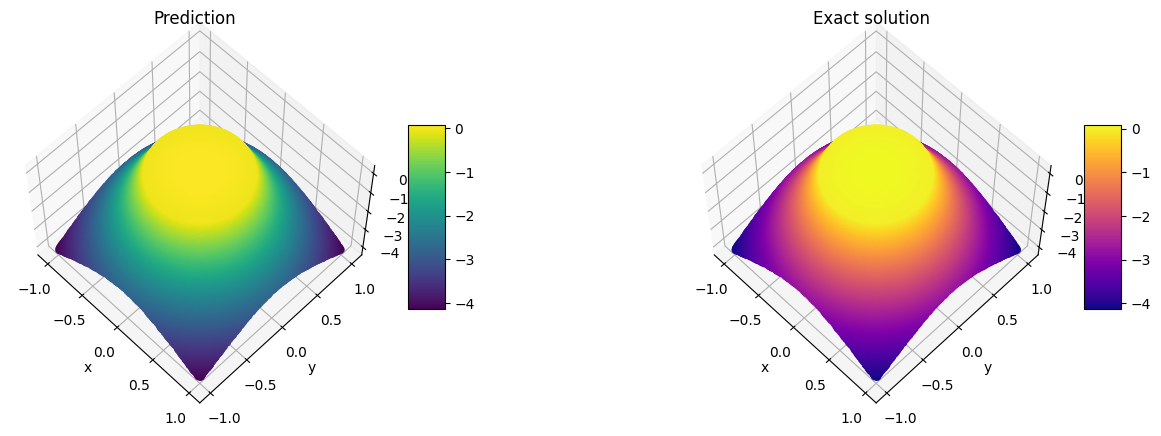

In [16]:
# set up a figure twice as wide as it is tall
fig = plt.figure(figsize=plt.figaspect(0.3))

#===============
#  First subplot
#===============
# set up the axes for the first plot
ax = fig.add_subplot(1, 2, 1, projection='3d')
surf = ax.scatter(x_ts, y_ts, upred_ts, c=upred_ts)
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Prediction')
ax.view_init(elev=60, azim=-45)

#===============
# Second subplot
#===============
# set up the axes for the second plot
ax = fig.add_subplot(1, 2, 2, projection='3d')
surf = ax.scatter(x_ts, y_ts, eu_ts, c=eu_ts, cmap='plasma')
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Exact solution')
ax.view_init(elev=60, azim=-45)
plt.show()

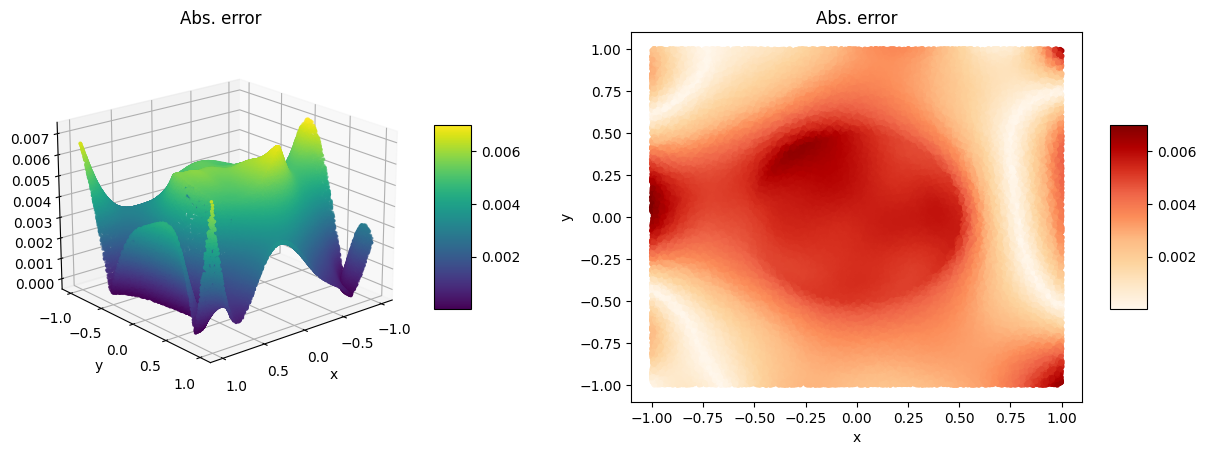

In [17]:
# set up a figure twice as wide as it is tall
fig = plt.figure(figsize=plt.figaspect(0.3))

#===============
#  First subplot
#===============
# set up the axes for the first plot
ax = fig.add_subplot(1, 2, 1, projection='3d')
surf = ax.scatter(x_ts, y_ts, err, c=err, cmap='viridis', marker = ".", s = 10)
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Abs. error')
ax.view_init(elev=20, azim=50)

#===============
# Second subplot
#===============
# set up the axes for the second plot
ax = fig.add_subplot(1, 2, 2)
surf = ax.scatter(x_ts, y_ts, c=err, cmap='OrRd', s = 10)
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Abs. error')
#ax.axis('equal')
plt.show()